# <center>Network Science</center>

## <center>Home Assignment #1: Power law</center>

### <center>Student: *Vyacheslav Shiryaev*</center>

# Problems

## Task 1.

Load [wordcounts](http://www.leonidzhukov.net/hse/2015/networks/data/wordcounts.txt) dataset. 
1. Check that Zipf's Law holds
2. Assuming that the data is distributed according to the Power Law, find
 * $\alpha$ of the distribution
 * mean sample variance $\sigma^2$
3. Produce summary of the frequencies: min, max, mean, median



## Solution

### **1. Check that Zipf's Law holds**

Firstly, let's import all packages that we will use:

In [191]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import groupby
%matplotlib inline

In [61]:
from __future__ import division
import matplotlib.pyplot as plt
import matplotlib
plt.xkcd()
import numpy as np
import pandas as pd
import scipy as sp
import operator
from itertools import groupby
%matplotlib inline

Now we can to upload **wordcounts** dataset and start working with it:

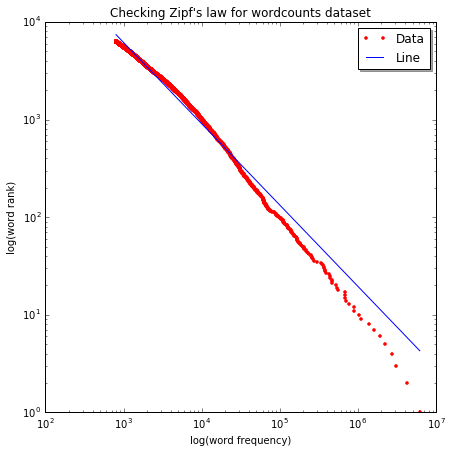

In [34]:
wordcounts = pd.read_csv('wordcounts.txt', sep = ' ', names = ['count', 'word'])
wordcounts.index += 1
wordcounts.head()

#data preparation
x = wordcounts['count']
y = wordcounts.index
x_est = np.log(x)
y_est = np.log(y)
s = len(x_est)

#estimation
X = np.vstack([np.ones(s), x_est]).T
Beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_est)

#plot
yt = np.exp(X.dot(Beta))
xt = x

fig, ax = plt.subplots()
fig.set_size_inches(7,7)
ax.loglog(x, y, '.r', label = 'Data')
ax.loglog(xt, yt, label = 'Line')
plt.ylabel('log(word rank)')
plt.xlabel('log(word frequency)')
ax.legend(loc='upper right', shadow=True)
plt.title('Checking Zipf\'s law for wordcounts dataset')

According to above placed figure, it can be assumed, dataset holds Zipf's law, but not perfectly.

### 2. Assuming that the data is distributed according to the Power Law, find
 * $\alpha$ of the distribution
 * mean sample variance $\sigma^2$

Firstly, let's calculate $\alpha$ of the distribution by Maximum Likelihood. We have an assumption that our data is distributed according to the Power Law. So, we can take xmin as a minimun value in the data.

In [128]:
n = len(x)
x_min = min(x)
alpha_hat = 1 + n / (np.sum(np.log(x / x_min)))
print x_min, alpha_hat

800 1.71941763006
16622


The minimum value is **800** and $\alpha =$ **1.71941763006**

According to formula that we deduced from maximum likelihood, our estimator relies on the choice of xmin - point, where our distributuion starts to behave like Power Law. Let's try to estimate the value of **x_min** parametr.

To find the best possible xmin value, we will run through our data set and use each data point as our x_min, truncate our data to include every data above and including our chosen x_min, use these data to compute empirical CDF and the theoretical CDF $P(x) = \frac{x}{x_min}^{-\alpha+1}$, where x is our data, and take the maximum of the absolute value of the difference between each theoretical and empirical CDF value, which is the Kolmogorov-Smirnoff statistic.

Thus, we would need to compare the power law cdf to the vector $(1,\frac{n-1}{n},...,\frac{2}{n}, \frac{1}{n})$, which is the empirical CDF. We do this for each data point and compile the KS statistics into one vector. Afterwards, we then pick the minimum of the KS statistics, find the corresponding x_min value, and designate this to be our parameter x_min.

In [129]:
e_cdf = pd.Series(range(n, 0, -1)) / n # emprerical CDF
e_cdf.index += 1
D = []

for x_min_temp in x:
    m_cdf = 1 - np.power(x / x_min_temp, -(alpha_hat - 1)) # model CDF
    D.append(max(abs(m_cdf - e_cdf)))
    
argmin = np.argmin(D)
x_min = x[argmin]    
print x_min

834


OK, thanks to KS estimator we now know the best choice for xmin and it is 834. Now we can use this new value to calculate $\alpha$ more precisely.

In [131]:
alpha_hat = 1 + n / (np.sum(np.log(x / x_min)))
print alpha_hat

1.74162436013


Now the answer is $\alpha = $ **1.74162436013**

Now we need to find sample variance of our data. However, as we know Power Law distributuon formulas of the second and third moments depend on $\alpha$. It makes sence to compute mean only for $\alpha > 2$ and variance for $\alpha > 3$. In our case we cannot make some conclusion based on **variance** because it diverges. The same goes for **mean**, though it is not so far from 2. But we can try to calculate both of them:

In [148]:
variance =  1. / n * np.sum((x - np.mean(x)) * (x - np.mean(x)))
print variance

15360778764.5


it's too much for our dataset, just as we thought.

### 3. Produce summary of the frequencies: min, max, mean, median

Now we can easily produce summary of the frequencies by numpy:

In [132]:
print np.min(x)
print np.max(x)
print np.median(x)
print np.mean(x)

800
6187267
2335.0
13566.6707819


It's important to note that we shoudn't believe this mean either, though it seems not far from some reasonable estimation.

## Task 2.

Find and plot PDF and CDF for the following networks:
* [Routing network](http://www.leonidzhukov.net/hse/2015/networks/data/network.txt)
* [Web graph](http://www.leonidzhukov.net/hse/2015/networks/data/web_Stanford.txt)
* [Facebook network](http://www.leonidzhukov.net/hse/2015/networks/data/fb_Princeton.txt)


1. Are they correspondent to power law?
2. Find max and mean values of incoming and outcoming node degrees
3. Find $\alpha$ via Maximum Likelihood and calculate $\sigma^2$
4. Determine $x_{min}$ via Kolmogorov-Smirnov test

## Solution

### 1. Find and plot PDF and CDF for the networks. Are they correspondent to Power Law?

Firstly we need to find and plot PDF, CDF and cCDF for each of the networks and just check, is it looks like the Power Law distribution or not. Sampling techiques won't be used in this task to avoid wrong assumptions about networks. However, solution doesn't promise to be fast.

Let's deal with the first network

In [189]:
first_nw = pd.read_csv('network.txt', sep = ' ', names = ['f', 's'])

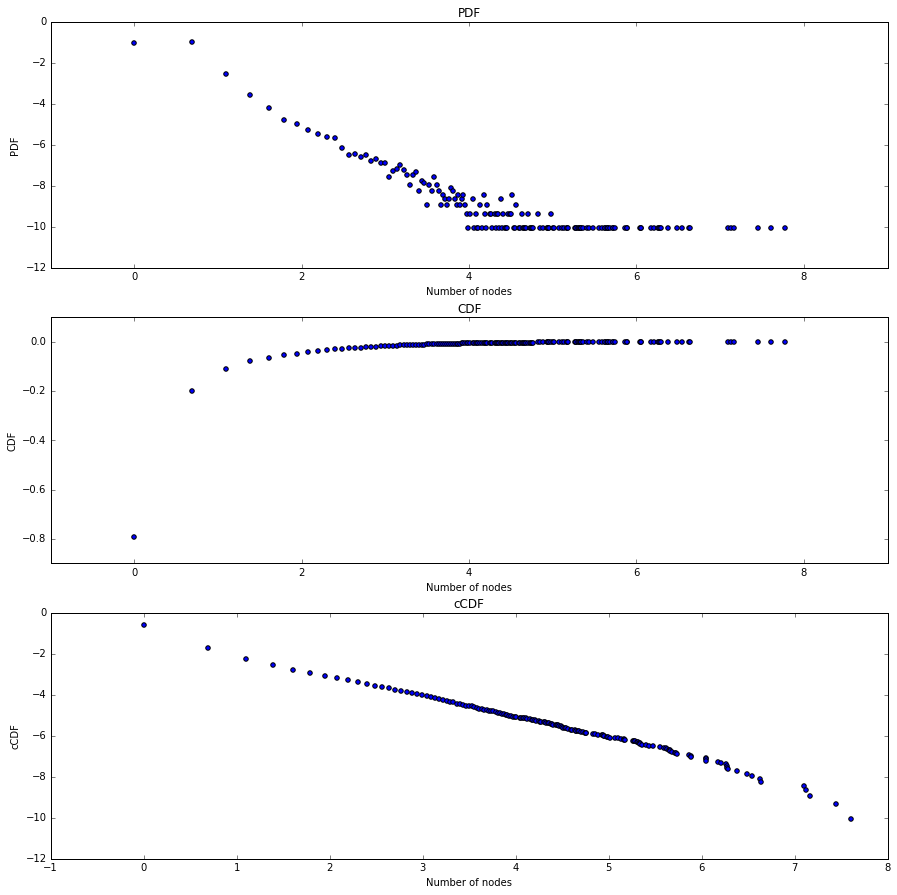

In [281]:
n = max(max(first_nw.f),max(first_nw.s))
nks = np.zeros(n + 1)

# counting degree of each node
for i in xrange(len(first_nw.f)):
    nks[first_nw.f[i]] = nks[first_nw.f[i]] + 1
    nks[first_nw.s[i]] = nks[first_nw.s[i]] + 1
    
nks = nks[1:] # there is no node 0
nks = sorted(nks)
new_nks = [len(list(group)) for key, group in groupby(nks)]
degrees = [list(group)[0] for key, group in groupby(nks)]


PDF = pd.Series(new_nks) / n
CDF = np.cumsum(PDF)
cCDF = 1 - CDF

#plot
fig = plt.figure(2)
fig.set_size_inches(15, 15, forward=True)
ax = plt.subplot(311)
ax.scatter(np.log(degrees), np.log(PDF))
ax.set_title('PDF')
ax.set_xlabel('Number of nodes')
ax.set_ylabel('PDF')

ax2 = plt.subplot(312)
ax2.scatter(np.log(degrees), np.log(CDF))
ax2.set_title('CDF')
ax2.set_xlabel('Number of nodes')
ax2.set_ylabel('CDF')

ax3 = plt.subplot(313)
ax3.scatter(np.log(degrees), np.log(cCDF))
ax3.set_title('cCDF')
ax3.set_xlabel('Number of nodes')
ax3.set_ylabel('cCDF')
plt.show()


As we can see, it looks like the Power Law.

Now let's deal with the second network.

In [256]:
second_nw = pd.read_csv('web_Stanford.txt', sep = '\t', dtype = np.int, names = ['f', 't'], skiprows=4)

In [269]:
n = max(max(second_nw.f),max(second_nw.t))
in_edges = np.zeros(n + 1)
out_edges = np.zeros(n + 1)

# counting in / out degree of each node
for i in xrange(len(second_nw.f)):
    #print i, second_nw.t[i], second_nw.f[i]
    in_edges[second_nw.t[i]] += 1
    out_edges[second_nw.f[i]] += 1

In [270]:
# functions for in edges
in_nks = sorted(in_edges)
new_in_nks = [len(list(group)) for key, group in groupby(in_nks)]
in_degrees = [list(group)[0] for key, group in groupby(in_nks)]
in_PDF = pd.Series(new_in_nks)/n
in_CDF = np.cumsum(in_PDF)
in_cCDF = 1 - in_CDF

# functions for out edges
out_nks = sorted(out_edges)
new_out_nks = [len(list(group)) for key, group in groupby(out_nks)]
out_degrees = [list(group)[0] for key, group in groupby(out_nks)]
out_PDF = pd.Series(new_out_nks)/n
out_CDF = np.cumsum(out_PDF)
out_cCDF = 1 - out_CDF

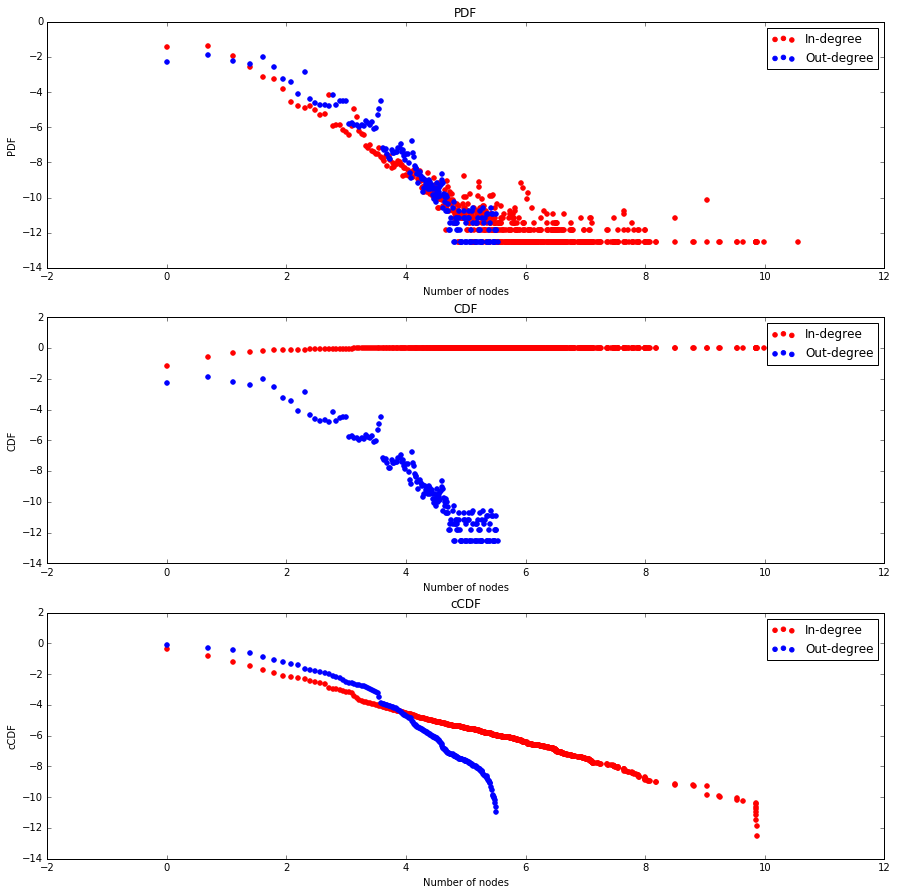

In [272]:
#plot
fig = plt.figure(3)
fig.set_size_inches(15, 15, forward=True)
ax = plt.subplot(311)
s1 = ax.scatter(np.log(in_degrees), np.log(in_PDF), color = 'red')
s2 = ax.scatter(np.log(out_degrees), np.log(out_PDF), color = 'blue')
ax.legend((s1, s2), ('In-degree', 'Out-degree'))
ax.set_title('PDF')
ax.set_xlabel('Number of nodes')
ax.set_ylabel('PDF')

ax2 = plt.subplot(312)
s3 = ax2.scatter(np.log(in_degrees), np.log(in_CDF), color = 'red')
s4 = ax2.scatter(np.log(out_degrees), np.log(out_PDF), color = 'blue')
ax2.legend((s3, s4), ('In-degree', 'Out-degree'))
ax2.set_title('CDF')
ax2.set_xlabel('Number of nodes')
ax2.set_ylabel('CDF')

ax3 = plt.subplot(313)
s5 = ax3.scatter(np.log(in_degrees), np.log(in_cCDF), color = 'red')
s6 = ax3.scatter(np.log(out_degrees), np.log(out_cCDF), color = 'blue')
ax3.legend((s5, s6), ('In-degree', 'Out-degree'))
ax3.set_title('cCDF')
ax3.set_xlabel('Number of nodes')
ax3.set_ylabel('cCDF')
plt.show()

As we can see, it looks like Power Law too.

Now let's deal with the third network.

In [282]:
third_nw = pd.read_csv('fb_Princeton.txt', sep = ' ', dtype = np.int, names = ['f', 's'], skiprows=4)

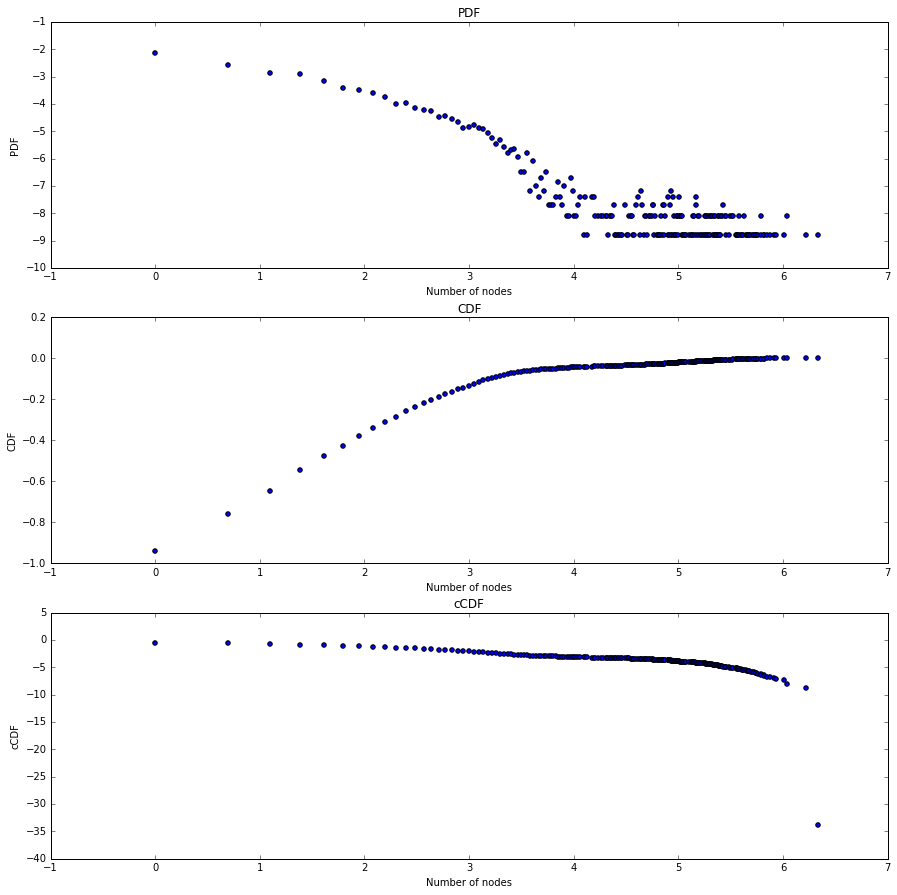

In [283]:
n = max(max(third_nw.f),max(third_nw.s))
nks = np.zeros(n + 1)

# counting degree of each node
for i in xrange(len(first_nw.f)):
    nks[third_nw.f[i]] = nks[third_nw.f[i]] + 1
    nks[third_nw.s[i]] = nks[third_nw.s[i]] + 1


nks = nks[1:] # there is no node 0
nks = sorted(nks)
new_nks = [len(list(group)) for key, group in groupby(nks)]
degrees = [list(group)[0] for key, group in groupby(nks)]


PDF = pd.Series(new_nks) / n
CDF = np.cumsum(PDF)
cCDF = 1 - CDF

fig = plt.figure(2)
fig.set_size_inches(15, 15, forward=True)
ax = plt.subplot(311)
ax.scatter(np.log(degrees), np.log(PDF))
ax.set_title('PDF')
ax.set_xlabel('Number of nodes')
ax.set_ylabel('PDF')

ax2 = plt.subplot(312)
ax2.scatter(np.log(degrees), np.log(CDF))
ax2.set_title('CDF')
ax2.set_xlabel('Number of nodes')
ax2.set_ylabel('CDF')

ax3 = plt.subplot(313)
ax3.scatter(np.log(degrees), np.log(cCDF))
ax3.set_title('cCDF')
ax3.set_xlabel('Number of nodes')
ax3.set_ylabel('cCDF')
plt.show()


This distrubtion doesn't really look like a Power Law.

### 2. Find max and mean values of incoming and outcoming node degrees

Incoming and outcoming node degree can be apply only for the second network. Next, it will be only about the second network.

In [289]:
print 'min Incoming: ', in_nks[0]
print 'min Outcoming: ', out_nks[0]
print 'max Incoming: ', in_nks[-1]
print 'max Outcoming: ', out_nks[-1]
print 'mean Incoming: ', np.mean(in_nks)
print 'mean Outcoming: ', np.mean(out_nks)

min Incoming:  0.0
min Outcoming:  0.0
max Incoming:  38606.0
max Outcoming:  255.0
mean Incoming:  8.20313652875
mean Outcoming:  8.20313652875


It is interesting, that means of incoming and outcoming degrees are equal. However, it's hard to say either this mean is trustworthy or not before $\alpha$ estimation for this Power Law distributions. Let's look at medians:

In [290]:
print 'median Incoming: ', np.median(in_nks)
print 'median Outcoming: ', np.median(out_nks)

median Incoming:  2.0
median Outcoming:  5.0


Well, it might mean that some average web page have more outcoming edges than incoming

### 3. Find $\alpha$ via Maximum Likelihood and calculate $\sigma^2$

The same job was done in the first task. It's obvious, Power Law distribution starts not from the minimum element in out sample (because it's equal to zero). So, x_min will be equal to 1 and nodes with zero degree will be omited.

In [345]:
x_min = 1

#only nonzero valuse
nonzero_in_nks = pd.Series(in_nks)
nonzero_in_nks = nonzero_in_nks[nonzero_in_nks.values > 0]

alpha_in_hat = 1 + len(nonzero_in_nks) / (np.sum(np.log(np.array(nonzero_in_nks) / x_min)))
print x_min
print alpha_in_hat

#only nonzero valuse
nonzero_out_nks = pd.Series(out_nks)
nonzero_out_nks = nonzero_out_nks[nonzero_out_nks.values > 0]

alpha_out_hat = 1 + len(nonzero_out_nks) / (np.sum(np.log(np.array(nonzero_out_nks) / x_min)))
print x_min
print alpha_out_hat


1
1.95412784401
1
1.62618016321


Good, for In-degree $\alpha = $ **1.95412784401** and $\alpha = $ **1.62618016321** for Out-degree. Now, let's find the real x_min of our Power Law. Komogorov-Smirnoff test wiil be used

In [352]:
# KS test for in edges
n_len = len(nonzero_in_nks)
e_cdf = np.array(range(n_len, 0, -1)) / float(n_len) # emprerical CDF
D = []

for x_min_temp in in_degrees[1:]:
    m_cdf = 1 - np.power(np.array(nonzero_in_nks) / x_min_temp, -(alpha_in_hat - 1)) # model CDF
    D.append(max(abs(m_cdf - e_cdf)))
    
argmin = np.argmin(D)
print argmin
x_min = nonzero_in_nks[arg + nonzero_in_nks.index.min()]    
print x_min

0
1.0


In [353]:
# KS test for out edges
n_len2 = len(nonzero_out_nks)
e_cdf = np.array(range(n_len2, 0, -1)) / float(n_len2) # emprerical CDF
D = []

for x_min_temp in out_degrees[1:]:
    m_cdf = 1 - np.power(np.array(nonzero_out_nks) / x_min_temp, -(alpha_out_hat - 1)) # model CDF
    D.append(max(abs(m_cdf - e_cdf)))
    
argmin = np.argmin(D)
print argmin
x_min = nonzero_out_nks[arg + nonzero_out_nks.index.min()]    
print x_min

0
1.0


As we see, Kolmogoroff Smirnoff test gave us the same x_min results. Moreover, If we look at our plots carefully, it can be noted, that Incoming-degree's cCDF is a straight line from the very beginning, whereas Outcoming-degree's cCDF consists of several interval on which it looks like a straight line.